# Мастерская № 1 "Startups operations/close predictions"

### Описание проекта 
***Вам предстоит работать с табличными данными, в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы. Вам нужно предсказать, какие из них закроются, а какие нет.***


### Цель проекта 
1. Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
2. Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).



### Исходные данные 
***Датасет состоит из двух файлов (+пример с выгрузкой): тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'***
- kaggle_startups_train.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.\
    name - Название стартапа\
    category_list - Список категорий, к которым относится стартап\
    funding_total_usd - Общая сумма финансирования в USD\
    status - Статус стартапа (закрыт или действующий)\
    country_code - Код страны\
    state_code - Код штата\
    region - Регион\
    city - Город\
    funding_rounds - Количество раундов финансирования\
    founded_at - Дата основания\
    first_funding_at - Дата первого раунда финансирования\
    last_funding_at - Дата последнего раунда финансирования\
    closed_at - Дата закрытия стартапа (если применимо)\
    lifetime - Время существования стартапа в днях
- kaggle_startups_sample_submit.csv - файл с примером предсказаний в правильном формате.
    name - идентификатор (название) стартапа в тестовом наборе.\
    status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].


# Загрузка и ознакомление с данными

In [58]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import phik
import shap
import warnings
from scipy.stats import spearmanr, shapiro, stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.model_selection import cross_val_score

In [59]:
warnings.filterwarnings('ignore')

In [60]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25

In [61]:
df_test = pd.read_csv(r"C:\Users\Александр\Desktop\Workshop\Datasets\kaggle_startups_test.csv")
df_train = pd.read_csv(r"C:\Users\Александр\Desktop\Workshop\Datasets\kaggle_startups_train.csv")

In [62]:
display('df_test:', df_test.head())
display('df_train:', df_train.head())

'df_test:'

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.00,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.00,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


'df_train:'

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.00,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [63]:
display('df_test:', df_test.info())
display('df_train:', df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


'df_test:'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


'df_train:'

None

***В целом проблем с данными нет, но как обычно дата имеет тип данных object изменим его.***

# Предварительная обработка

In [64]:
df_test['first_funding_at'] = pd.to_datetime(df_test['first_funding_at'], format='%Y-%m-%d')
df_test['last_funding_at'] = pd.to_datetime(df_test['first_funding_at'], format='%Y-%m-%d')

In [65]:
display('df_test:', df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


'df_test:'

None

In [66]:
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'], format='%Y-%m-%d')
df_train['last_funding_at'] = pd.to_datetime(df_train['first_funding_at'], format='%Y-%m-%d')

In [67]:
display('df_train:', df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  object        
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(9)
memory 

'df_train:'

None

In [68]:
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'], format='%Y-%m-%d')

In [69]:
display('df_train:', df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  object        
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1), object(8)
memory 

'df_train:'

None

***Тип данных успешно изменен.***

In [70]:
df_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

***В тестовой выборке в некоторых стобцах имеются пропуски, также в столбце category_list очень много уникальных значений с непонятными разделителями, заменим эти значения на первую категорию до разделителя.*** 

In [71]:
df_test['category_list'] = df_test['category_list'].str.split('|').str[0]

In [72]:
for i in list(df_test['category_list'].unique()):
    df_test.loc[(df_test['category_list'] == i) & (df_test['funding_total_usd'].isna() == True), 'funding_total_usd'] = df_test[df_test['category_list']==i] ['funding_total_usd'].median()

***Заполним пропуски в столбце funding_total_usd медианным значением funding_total_usd по category_list.***

In [73]:
df_test['funding_total_usd'] = df_test['funding_total_usd'].fillna(df_test['funding_total_usd'].median())

***Остальные пропуски в funding_total_usd заполним медианным значением***

In [74]:
df_test.isna().sum()

name                    0
category_list         591
funding_total_usd       0
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

***Пропуски в funding_total_usd заполнены, в остальных категориальных стобцах сделать это довольно таки проблематично оставим их, так как из тестового датасета их удалять не желательно.***

In [75]:
df_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

***В тренировочном датасете также очень много пропусков, обработаем их.***

In [76]:
df_train['status'] = df_train['status'].apply(lambda x: 1 if x == 'operating' else 0)

***Но перед обработкой приведем датасет в нужный вид для обучения, заменим целевой признак на 0 и 1***

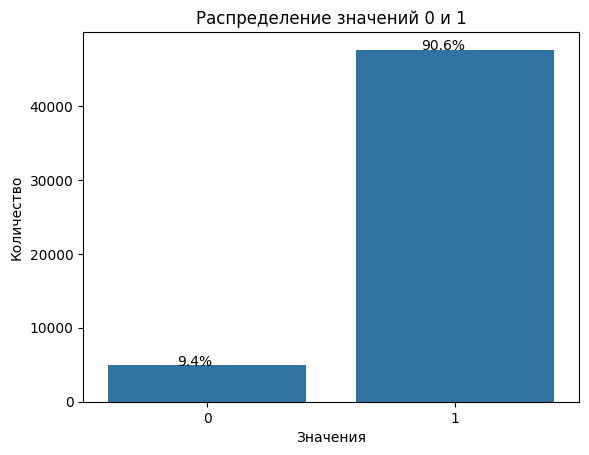

In [77]:
ax = sns.countplot(x='status', data=df_train)

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
# Настройка графика
plt.title('Распределение значений 0 и 1')
plt.xlabel('Значения')
plt.ylabel('Количество')

# Отображение графика
plt.show()

***Для того чтобы решить что именно делать с пропущенными данными, построили распределение нулей и едениц в тренировочной выборке. Наблюдается дибаланс классов.***

In [78]:
columns = ['category_list', 'name', 'country_code', 'state_code', 'region', 'city']
df_train = df_train.dropna(subset=columns)

***Тем не менее попробуем удалить все пропуски в категориальных значениях, так как их заполнение является давольно таки проблематичным занятием, и посмотреть как изменится дисбаланс классов.***

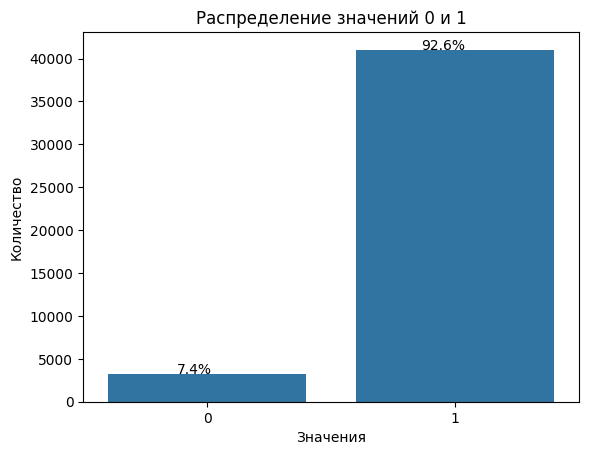

In [79]:
ax = sns.countplot(x='status', data=df_train)

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
# Настройка графика
plt.title('Распределение значений 0 и 1')
plt.xlabel('Значения')
plt.ylabel('Количество')

# Отображение графика
plt.show()

***Дисбаланс сохраняется, уменьшив нули на 2% и увеличив единицы на те же 2%, но тем не менее и на таких данных можно обучить модель, главное выявить необходимые признаки для обучения.***

In [80]:
df_train['category_list_1'] = df_train['category_list'].str.split('|').str[0]

***Создаем новый столбец с категориями, потому что еще не однозначно что они подойдут нам для обучения***

In [81]:
df_train['category_list_1'].nunique()

699

***Количество учикальных значений сократилось в разы.***

In [82]:
for i in list(df_train['category_list_1'].unique()):
    df_train.loc[(df_train['category_list_1'] == i) & (df_train['funding_total_usd'].isna() == True), 'funding_total_usd'] = df_train[df_train['category_list_1']==i] ['funding_total_usd'].median()

In [83]:
df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(df_train['funding_total_usd'].median())

***Заполним столбец funding_total_usd также как в тестовом датасете***

# Исследовательский анализ данных

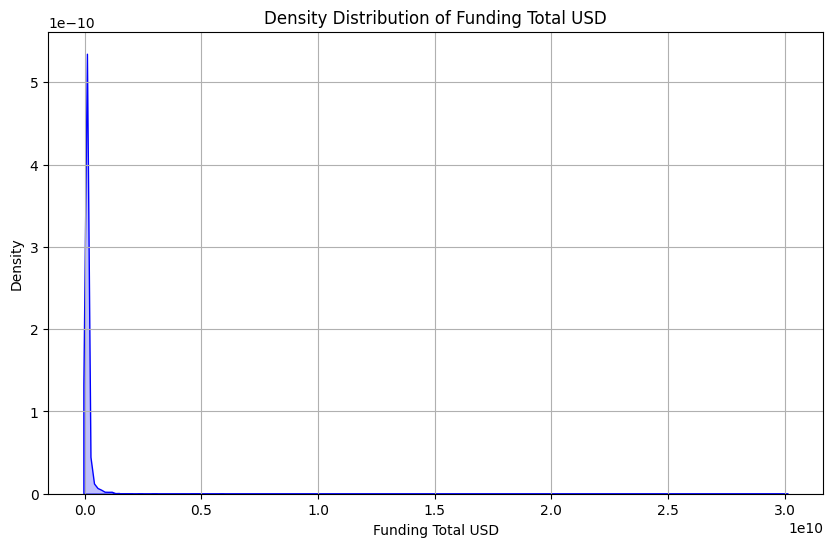

In [84]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['funding_total_usd'], fill=True, color='blue')
plt.title('Density Distribution of Funding Total USD')
plt.xlabel('Funding Total USD')
plt.ylabel('Density')
plt.grid(True)
plt.show()

***Распределение данных funding_total_usd выглядит печально, похоже на похудевшего Пуассона.*** 

In [85]:
df_train.sort_values(by='funding_total_usd')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_list_1
11405,Sentic Technologies Inc,Information Technology|Internet|SaaS|Search Ma...,1.00,1,USA,IL,Chicago,Chicago,1,2014-02-01,2015-11-12,2015-11-12,NaT,Information Technology
48687,Synergia Pharma,Pharmaceuticals,2.00,0,USA,CA,SF Bay Area,San Francisco,1,2001-04-22,2003-02-11,2003-02-11,2004-08-30,Pharmaceuticals
27332,Soundctl,Audio|Video Streaming,2.00,1,USA,CA,SF Bay Area,Mountain View,1,2015-07-01,2015-09-23,2015-09-23,NaT,Audio
29015,Romo Wind,Innovation Engineering|Optimization|Services,5.00,1,DEU,8,DEU - Other,Straße,1,2011-08-18,2013-04-26,2013-04-26,NaT,Innovation Engineering
51354,Sight Diagnostics,Health Care,6.00,1,ISR,6,Tel Aviv,Jerusalem,1,2011-01-01,2014-11-01,2014-11-01,NaT,Health Care
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29080,Charter Communications,Internet|Telecommunications|Television|Video,5162513431.00,1,USA,CT,Hartford,Stamford,2,1993-01-01,2009-11-21,2009-11-21,NaT,Internet
36634,Sberbank,Banking|Finance,5800000000.00,1,RUS,48,Moscow,Moscow,1,2013-03-20,2014-07-07,2014-07-07,NaT,Banking
15976,Clearwire,Internet|Mobile,5820000000.00,1,USA,WA,Seattle,Kirkland,6,2003-10-01,2001-12-11,2001-12-11,NaT,Internet
4557,Uber,Automotive|Design|Limousines|Public Transporta...,8207450000.00,1,USA,CA,SF Bay Area,San Francisco,13,2009-03-01,2009-08-01,2009-08-01,NaT,Automotive


***При просмотре данных выявлено, что есть как и очень маленькие значения по 1$ так и очень большие, порядком десятка миллиардов, отфильтруем их*** 

In [86]:
df_train['funding_total_usd'].describe([0.05, 0.95])

count         44315.00
mean       16181728.88
std       171724718.67
min               1.00
5%            40000.00
50%         2000000.00
95%        60642011.00
max     30079503000.00
Name: funding_total_usd, dtype: float64

In [87]:
fil_1 = df_train['funding_total_usd'].quantile(0.05)
fil_2 = df_train['funding_total_usd'].quantile(0.95)

In [88]:
df_train = df_train[df_train['funding_total_usd'] > fil_1]
df_train = df_train[df_train['funding_total_usd'] < fil_2]

***Провели удаление значений из датасета которые меньше 5% квантиля и больше 95% квантиля***

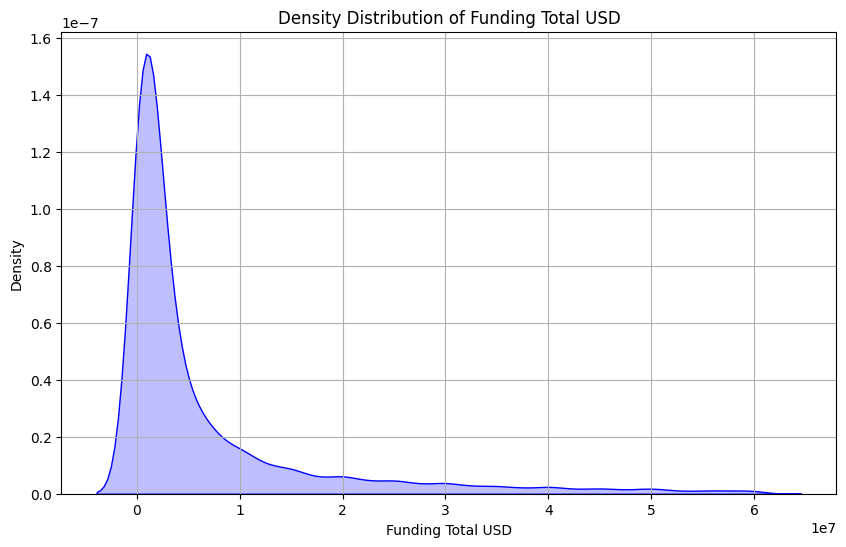

In [89]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['funding_total_usd'], fill=True, color='blue')
plt.title('Density Distribution of Funding Total USD')
plt.xlabel('Funding Total USD')
plt.ylabel('Density')
plt.grid(True)
plt.show()

***Вот теперь то похоже на нормального Пуассона***

In [90]:
df_graph = list(df_train.groupby('category_list_1')['category_list_1'].count().sort_values(ascending=False).head(10).index)

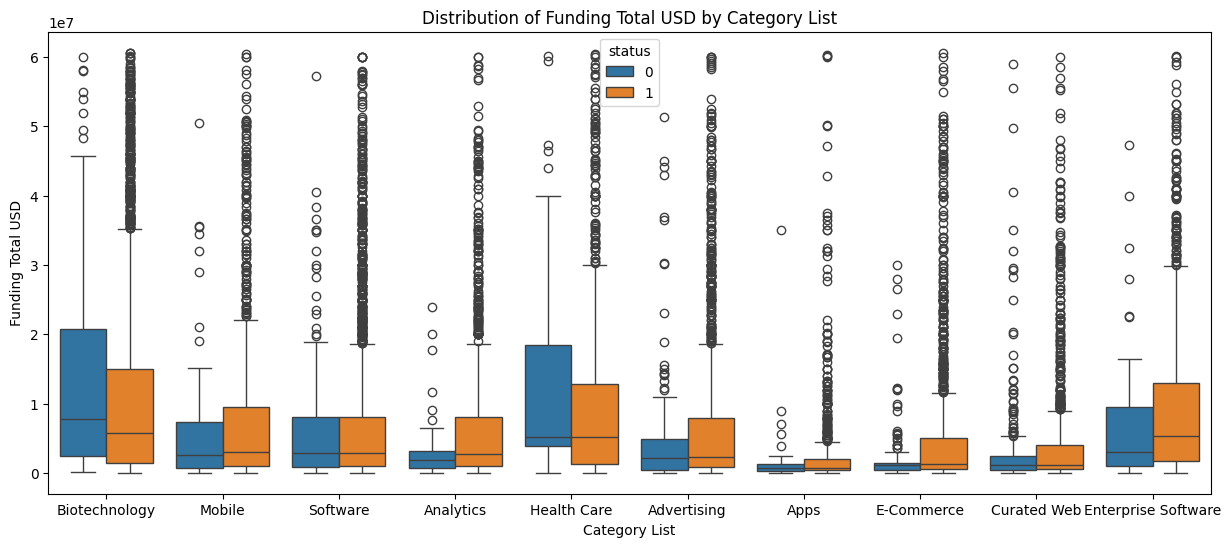

In [91]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='category_list_1', y='funding_total_usd', hue='status', data=df_train[df_train['category_list_1'].isin(df_graph)])
plt.title('Distribution of Funding Total USD by Category List')
plt.xlabel('Category List')
plt.ylabel('Funding Total USD')
plt.show()

***Из боксплотов для закрытых и открытых стартапов для топ 10 категорий, что больше всего денег было собрано в областях здоровья, биотехнологий и программного обеспечения, также можно обратить внимание что у большинства категорий собранные деньги для закрытых стартапов не уступают, а в некоторых случаях даже превосходят, открытые стартапы.***

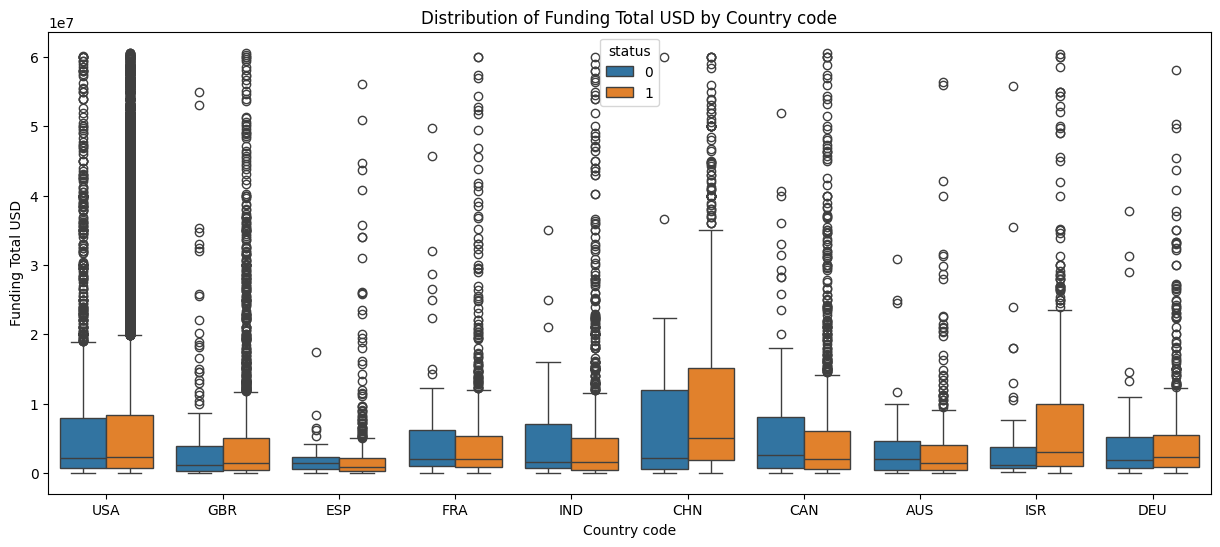

In [92]:
df_graph1 = list(df_train.groupby('country_code')['country_code'].count().sort_values(ascending=False).head(10).index)
plt.figure(figsize=(15, 6))
sns.boxplot(x='country_code', y='funding_total_usd', hue='status', data=df_train[df_train['country_code'].isin(df_graph1)])
plt.title('Distribution of Funding Total USD by Country code')
plt.xlabel('Country code')
plt.ylabel('Funding Total USD')
plt.show()

***Из боксплотов для закрытых и открытых стартапов для топ 10 стран видно, что больше всего денег было собрано в китае и США, также можно обратить внимание что у большинства стран собранные деньги для закрытых стартапов не уступают, а в некоторых случаях даже превосходят, открытые стартапы.***

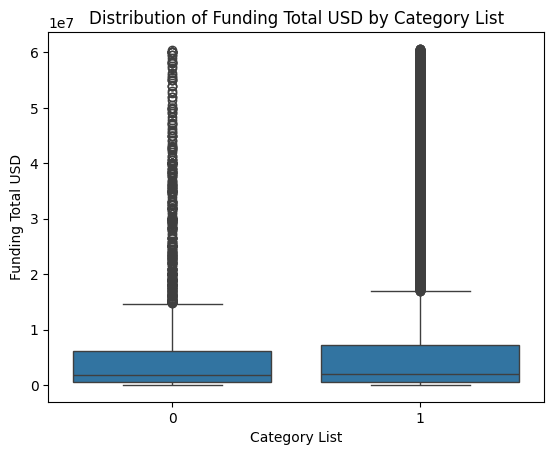

In [93]:
sns.boxplot(x='status', y='funding_total_usd',  data=df_train)
plt.title('Distribution of Funding Total USD by Category List')
plt.xlabel('Category List')
plt.ylabel('Funding Total USD')
plt.show()

***Из собранных денег в общем для открытых и закрытых стартапов видно, что они практически одинаковы.***

# Проверка на мультиколлинеарность и разработка новых признаков

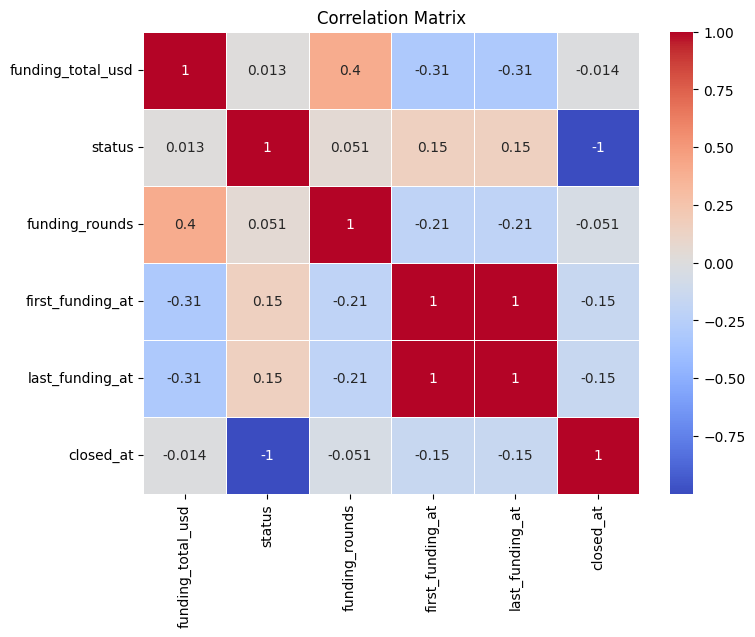

In [94]:
corr_matrix = df_train.drop(columns = df_train.select_dtypes(include=['object', 'category']).columns).corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

***lust_funding_at полностью коррелирует с first_funding_at и наоборот, значит данные полностью идентичны. Также наблюдается корреляция между closed_at и целевым признаком, значит это утечка целевого признака.***

In [95]:
df_train = df_train.drop(columns=['category_list'])
df_train = df_train.rename(columns={'category_list_1':'category_list' })

***Оставим только один category_list где написана одна категория.***

In [96]:
df_train['closed_at'] = df_train['closed_at'].fillna('2018-01-01')
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'], format='%Y-%m-%d')
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'], format='%Y-%m-%d')

In [97]:
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days

***Заполним пропуски в closed_at датой формирования датасета и посчитам время жизни каждого проекта***

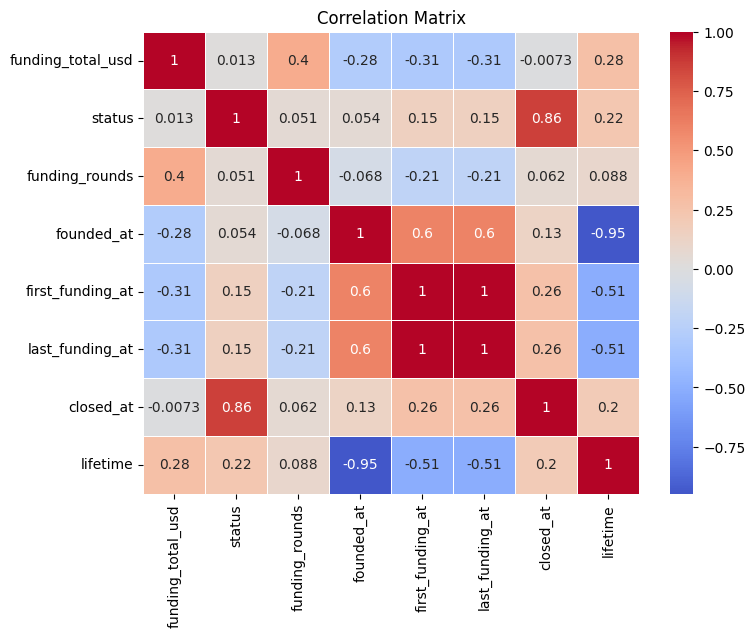

In [98]:
corr_matrix = df_train.drop(columns = df_train.select_dtypes(include=['object', 'category']).columns).corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

***У нового признака корреляции с целевым не наблюдается***

In [99]:
df_train.columns

Index(['name', 'funding_total_usd', 'status', 'country_code', 'state_code',
       'region', 'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at', 'closed_at', 'category_list', 'lifetime'],
      dtype='object')

In [100]:
df_train['first_funding_at_year'] = df_train['first_funding_at'].dt.year
df_test['first_funding_at_year'] = df_test['first_funding_at'].dt.year

df_train['first_funding_at_month'] = df_train['first_funding_at'].dt.month
df_test['first_funding_at_month'] = df_test['first_funding_at'].dt.month


***Так как first_funding_at дата использовать в обучении я не планирую создадим новые признаки, а именно first_funding_at_month и first_funding_at_year***

In [101]:
df_train = df_train.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'state_code', 'region', 'city'])

***Удалим не нужные для обучения признаки. Удаление категориальных признаков обусловлено тем, что оди взаимосвязаны с country_code***

In [102]:
df_train['funding_per_round'] = df_train['funding_total_usd'] / df_train['funding_rounds']

In [103]:
df_test['funding_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']

In [104]:
df_train['log_lifetime'] = np.log1p(df_train['lifetime'])
df_test['log_lifetime'] = np.log1p(df_test['lifetime'])

***Создадим новый признак funding_per_round и прологарифмируем лайфтайм так как он имеет очень большой диапазон значений***

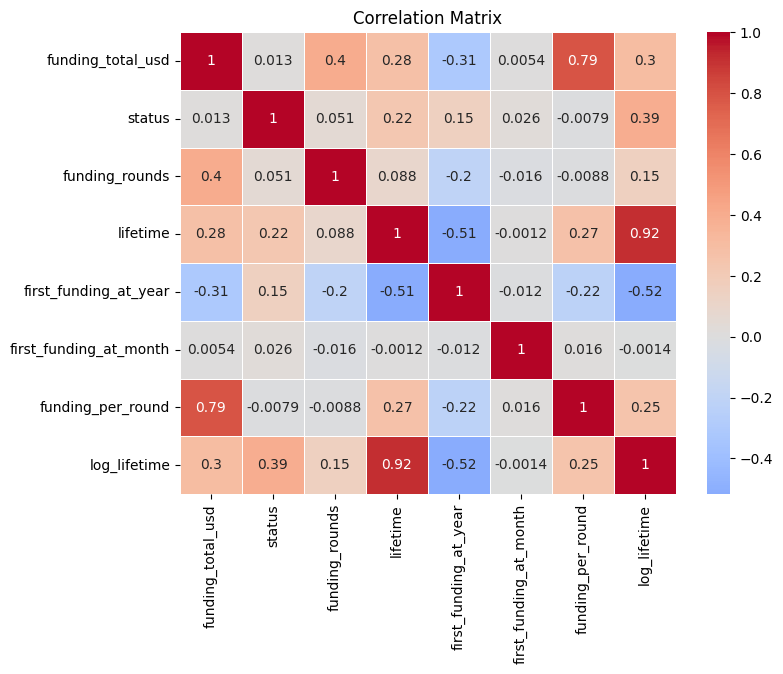

In [105]:
corr_matrix = df_train.drop(columns = df_train.select_dtypes(include=['object', 'category']).columns).corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

***Мультиколлинеарность не обнаружена***

# Обучение модели и предсказание

In [106]:
X_train = df_train.drop(columns=['status', 'name'])
y_train = df_train['status']


pipe_final_q = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
param_grid_q = [
    {
        'models': [CatBoostClassifier(cat_features=['country_code', 'category_list'])],
        'models__iterations': [500],
        'models__depth': [5],
        'models__learning_rate': [0.1],
        'models__verbose': [False] 
        
    }
    
]
grid_search_q = GridSearchCV(
    pipe_final_q,
    param_grid_q,
    n_jobs=-1,
    cv=5,
    scoring='f1',
    error_score='raise'
)
grid_search_q.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search_q.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid_search_q.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 <catboost.core.CatBoostClassifier object at 0x000001B7C9E41280>)])
Метрика лучшей модели на кросс-валидации: 0.9898613637157856


***В ходе выполнения проектной работы было поторачено довольно таки много времени, поэтому я решил оставить Catboost с этими параметрами. Поиск лучшей модели осуществлялся через GridSearchCV так как Optuna у меня работала двое суток и по итогу модель с её параметрами на платформе kaggle дала результат хуже чем эта.***

In [107]:
grid_search_q.best_params_

{'models': <catboost.core.CatBoostClassifier at 0x1b7c3de3dc0>,
 'models__depth': 5,
 'models__iterations': 500,
 'models__learning_rate': 0.1,
 'models__verbose': False}

In [108]:
df_test = df_test[X_train.columns]

In [109]:
categorical_features = df_test.select_dtypes(include=['object', 'category']).columns
df_test[categorical_features] = df_test[categorical_features].fillna('n')
df_train_2 = pd.read_csv(r"C:\Users\Александр\Desktop\Workshop\Datasets\kaggle_startups_train.csv")
df_train_2['category_list'] = df_train_2['category_list'].str.split('|').str[0]

In [110]:
df_test['status']= grid_search_q.predict(df_test[X_train.columns])

In [111]:
df_test['status'] = df_test['status'].apply(lambda x: 'operating' if x == 1 else 'closed')

In [112]:
df_test2 = pd.read_csv(r"C:\Users\Александр\Desktop\Workshop\Datasets\kaggle_startups_test.csv")
df_test2['status'] = df_test['status']
df_test2[['name','status']].to_csv('submission.csv',index=False)

***Итоговый результат на платформе Kaggle метрики f1_score оказался равен 0.86678, было потрачено достаточно много времени на поиск лучшей модели, но тем не менее улучшить результат не получилось. Полученный результат считаю достаточным для определения успешности того или иного стартапа.***

# SHAP анализ

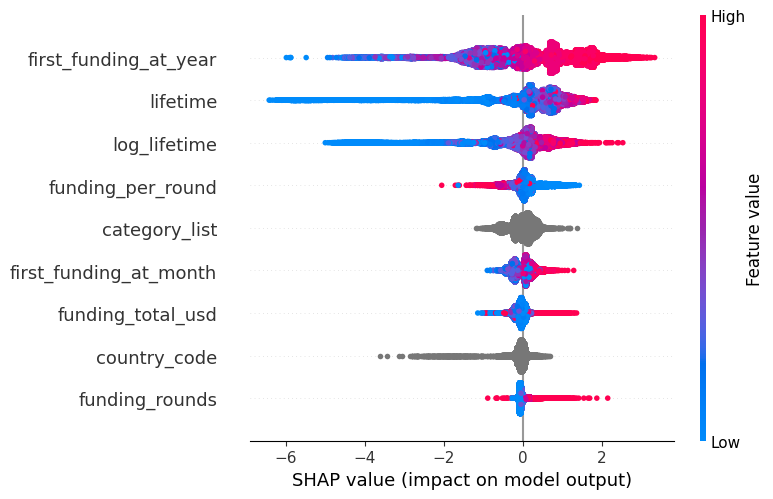

In [126]:
best_model = grid_search_q.best_estimator_.named_steps['models']
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
# Визуализация SHAP значений для тестовых данных
shap.summary_plot(shap_values, X_train)


In [116]:
X_train.columns

Index(['funding_total_usd', 'country_code', 'funding_rounds', 'category_list',
       'lifetime', 'first_funding_at_year', 'first_funding_at_month',
       'funding_per_round', 'log_lifetime'],
      dtype='object')

***Из графика видно, что наиболее значимыми признакми являются год первого фандинга и продолжительность жизни проекта. Это обосновано тем, что чем дольше живет проект тем вероятность того, что он закроется сокращается (это очевидно), а вот год первого фандинга я предполагаю, что в разные периоды времени у нас в мире была разная экономическая обстановка, и некоторые стартапы открывались на расцвете мировой экономики, а некоторые на спадах.*** 

# Общие выводы 

***В ходе выполнения проктной работы в тренировочном датасете были удалены все пропуски, также в нем наблюдался дисбаланс классов целевого признака. Из боксплотов для закрытых и открытых стартапов для топ 10 категорий, что больше всего денег было собрано в областях здоровья, биотехнологий и программного обеспечения, также можно обратить внимание что у большинства категорий собранные деньги для закрытых стартапов не уступают, а в некоторых случаях даже превосходят, открытые стартапы. Из боксплотов для закрытых и открытых стартапов для топ 10 стран видно, что больше всего денег было собрано в китае и США, также можно обратить внимание что у большинства стран собранные деньги для закрытых стартапов не уступают, а в некоторых случаях даже превосходят, открытые стартапы. Из собранных денег в общем для открытых и закрытых стартапов видно, что они практически одинаковы. В тренировочной выборке были сгенерированы новые признаки. В качестве модели для обучения использовалась CatBoost модель, которая на тестовой выборке показала довольно достойный результат. В качестве основных признаков для оценки стартапа необходимо испорльзовать год первого фандинга и продолжительность жизни стартапа.***